# Data Analysis

#### Load model and import libraries 

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('../data/MushroomDataset/processed_secondary_data.csv')

#### Checking how balanced our dataset is
Poisonous mushrooms have a class of "1", edible "0".

In [83]:
print(data['class'].value_counts(normalize=True))

class
1    0.554913
0    0.445087
Name: proportion, dtype: float64


The dataset is well balanced between posionous and edible mushrooms.

## Correlation between the numeric features

Lets check for low variance features

In [84]:
low_variance_cols = [col for col in data.columns if data[col].var() < 0.01]
print("Low-variance columns:", low_variance_cols)

Low-variance columns: ['stem_color_b', 'stem_color_l', 'stem_color_r', 'ring_type_m', 'habitat_p', 'habitat_u', 'habitat_w']


We could consider dropping these features 

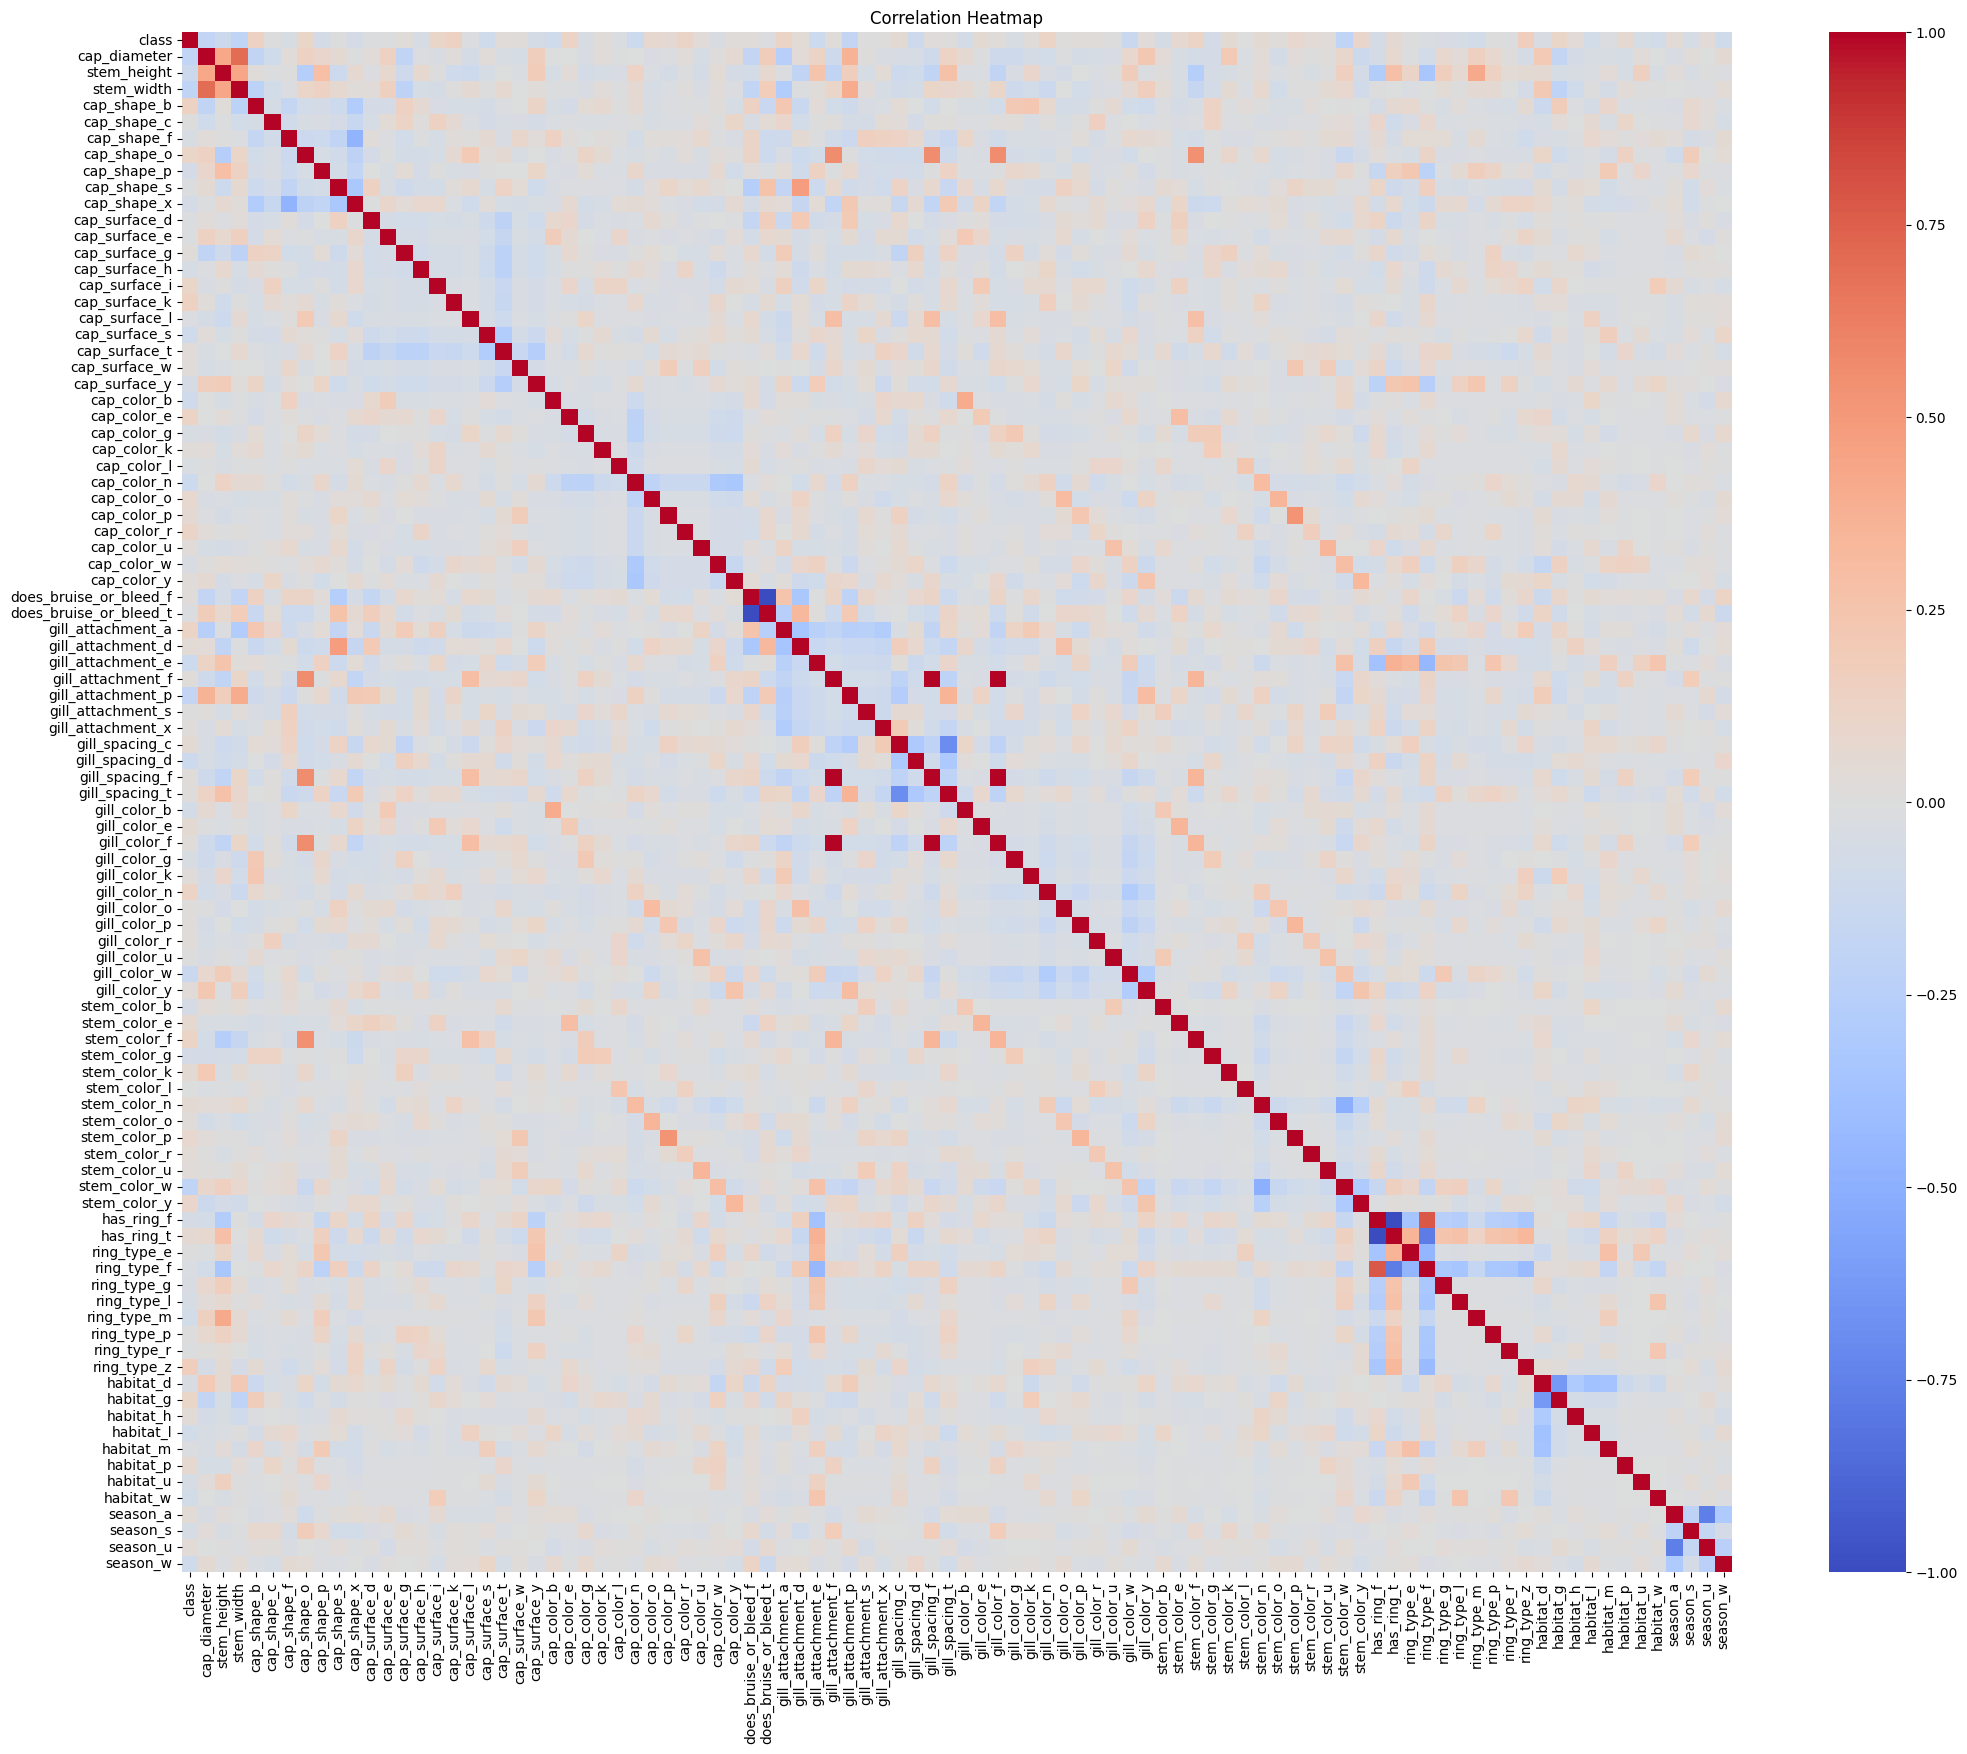

In [85]:

numeric_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(25,20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

- We can see that for the class column, there are no strong correlations with any of the features showing that no feature clearly indicates if a mushroom is poisonous or edible
- But we do see some strong correlations between some of the features. Lets find the top 20 correlations

In [86]:
correlation_pairs = correlation_matrix.where(~np.eye(correlation_matrix.shape[0], dtype=bool)).stack()

correlation_df = correlation_pairs.reset_index()
correlation_df.columns = ['Feature 1', 'Feature 2', 'Correlation']

# ignore duplicate pairs
correlation_df['Ordered Pair'] = correlation_df[['Feature 1', 'Feature 2']].apply(lambda x: tuple(sorted(x)), axis=1)
unique_correlation_df = correlation_df.drop_duplicates(subset='Ordered Pair').drop(columns='Ordered Pair')
unique_correlation_df = unique_correlation_df.reindex(unique_correlation_df['Correlation'].abs().sort_values(ascending=False).index)
top_correlations = unique_correlation_df.head(20)
print("Top unique correlations (positive and negative):")
print(top_correlations)

Top unique correlations (positive and negative):
                   Feature 1               Feature 2  Correlation
6768              has_ring_f              has_ring_t    -1.000000
3196  does_bruise_or_bleed_f  does_bruise_or_bleed_t    -1.000000
4233          gill_spacing_f            gill_color_f     1.000000
3671       gill_attachment_f          gill_spacing_f     1.000000
3675       gill_attachment_f            gill_color_f     1.000000
6770              has_ring_f             ring_type_f     0.780288
6863              has_ring_t             ring_type_f    -0.780288
8461                season_a                season_u    -0.765503
95              cap_diameter              stem_width     0.695330
4044          gill_spacing_c          gill_spacing_t    -0.687796
7708               habitat_d               habitat_g    -0.626131
689              cap_shape_o       gill_attachment_f     0.562095
695              cap_shape_o          gill_spacing_f     0.562095
699              cap_shape_

There are some strong correlations between some of the features. 
We will keep all the features for now and see how the model performs
Feeatures with =-1 we could remove because they are the same

Some features are perfect predictors of each other. They will be dropped to avoid multicollinearity. 
*  features (does_bruise_or_bleed_f, has_ring_f) can only take the value of true or false.
* features season_a and season_u have a correlation of -0.77
* gill_color_f and gill_attachment_f and gill_spacing_f are all perfectly correlated beacuse the signifiy the that the mushroom has no gill attachement, two will be dropped.
* has_ring_t and ring_type_f have a negative correlation of -0.78, as ring_type_f only occurs in the mushrooms which do not have a ring. 

In [87]:
data_selected = data.drop(columns=['does_bruise_or_bleed_f', 'has_ring_f', 'gill_color_f', 'gill_spacing_f', 'ring_type_f' ])

### Checking feature redundancy

In [88]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Explained variance ratio: [0.20470869 0.08395614]


The two principles PC1 and PC2 explain 29.43% of our variance which is pretty low. This means we probably have some redundant / less informative features. We should consider dropping them.

PCA without features with high correlation

In [89]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_selected)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Explained variance ratio: [0.21493268 0.07970485]


The explained variance ratios are quite similar before and after dropping the redundant features. 

# Checking for combinable features

In [90]:
pca_components = pd.DataFrame(
    data=pca.components_,
    columns=data.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

print("PCA Loadings:")
print(pca_components.T.head(10))

ValueError: Shape of passed values is (2, 89), indices imply (2, 94)

We can see that features with high loadings on the same principle component are likely to be combinable. 
We could consider combining them into a single feature.

Lets first check feature importance using random forest classifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(data, data["class"])
importances = pd.DataFrame({
    'Feature': data.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances.head(10))

              Feature  Importance
0               class    0.609642
3          stem_width    0.037812
1        cap_diameter    0.026512
2         stem_height    0.025600
70       stem_color_w    0.016168
44     gill_spacing_d    0.012995
57       gill_color_w    0.011204
40  gill_attachment_p    0.010172
81        ring_type_z    0.009014
4         cap_shape_b    0.008276


- We can see that stem_width and stem_height are the most important features again
- We can also see that there are features that have very low importance. We could consider dropping them

# Visualizing the Data for a better understanding of the real world

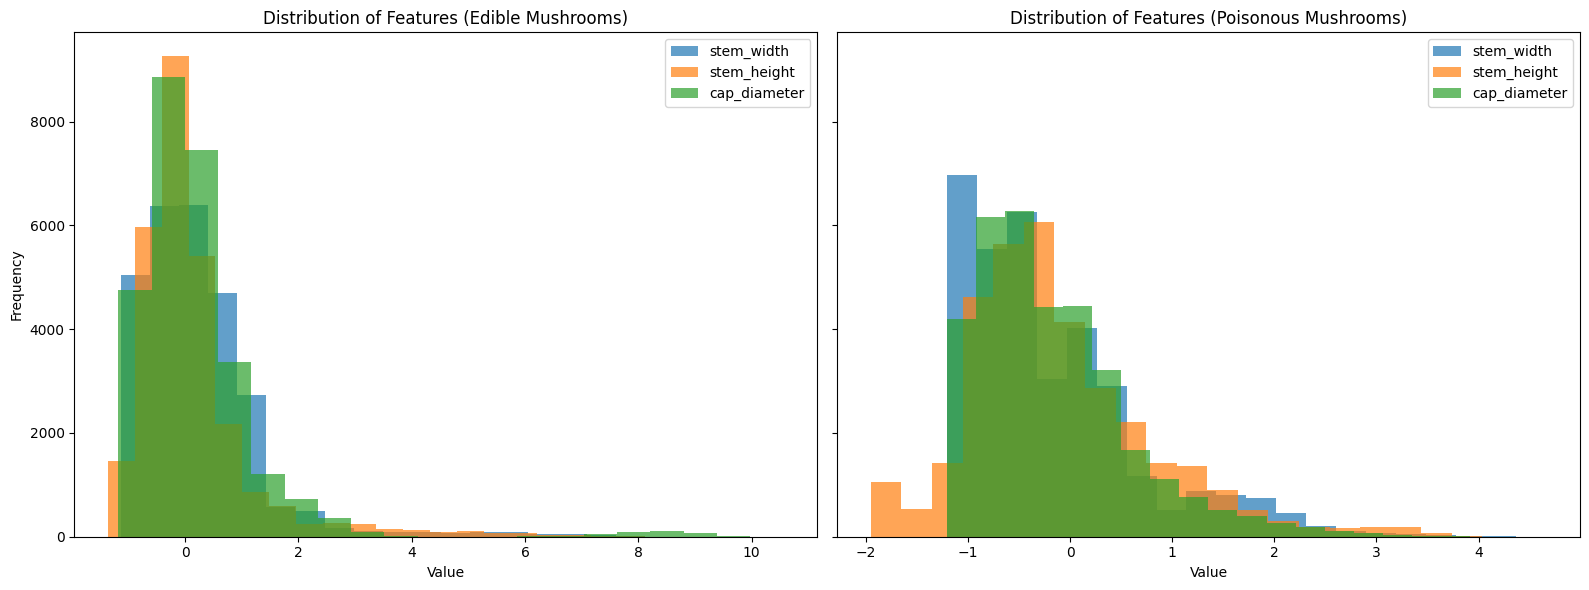

In [ ]:
edible_data = data[data['class'] == 0]
poisonous_data = data[data['class'] == 1]

# Plot settings
features = ['stem_width', 'stem_height', 'cap_diameter']
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Distribution for edible mushrooms
for feature in features:
    axes[0].hist(edible_data[feature], bins=20, alpha=0.7, label=feature)
axes[0].set_title('Distribution of Features (Edible Mushrooms)')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Distribution for poisonous mushrooms
for feature in features:
    axes[1].hist(poisonous_data[feature], bins=20, alpha=0.7, label=feature)
axes[1].set_title('Distribution of Features (Poisonous Mushrooms)')
axes[1].set_xlabel('Value')
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

We can see that:
- Edible mushrooms tend to be larger in height and cap diameter. So they mostly look thin, high and have a large cap diameter
- Poisonous mushrooms tend to have a large stem width but a smaller height and cap diameter.

# Conclusion

> TLDR: stem_width, stem_height, and cap_diameter are the most important features and we should consider using them in our model. There are very low importance features that we could consider dropping

1. **Feature Importance**:
   - Features such as `stem_width`, `cap_diameter`, and `stem_height` were identified as highly significant. These should be prioritized in the model.
   - Features with very low importance, like `ring_type_z` and `gill_color_w`, may be considered for removal to reduce noise.

2. **PCA Loadings**:
   - Features with high loadings on the same principal component (e.g., `cap_diameter`, `stem_width`, and `stem_height`) capture overlapping variance. These features can be combined into a composite variable to simplify the dataset.
   - Features with near-zero loadings, like `cap_shape_*`, contribute minimally to the variance and can be removed or aggregated.

3. **Correlation Analysis**:
   - Redundant features with perfect positive or negative correlations (e.g., `has_ring_f` and `has_ring_t`) should be dropped to avoid duplication.
   - Moderately correlated features, such as `cap_diameter` and `stem_width`, may be combined using aggregation or ratio methods to capture their shared information. 

In [ ]:
data.to_csv('../data/MushroomDataset/processed_secondary_data_after_analysis.csv', index=False)